# Defective detection of casting process


yolo 모델 가중치.h5, 학습한 casting, helmet, CNN의 h5 모델 파일은 용량상의 문제로 첨부하지 않았습니다.
yolo 모델 가중치는 darknet(https://pjreddie.com/)에서 다운 가능합니다.

python 3.7
keras 2.10
tensorflow-gpu 2.10.1
버전에서 작업하였습니다.

실제 모델 학습시 yolo3-keras의 model.py와 yolo.py등에서 절대경로를 사용하여 경로를 수정해야 합니다.


### 목표

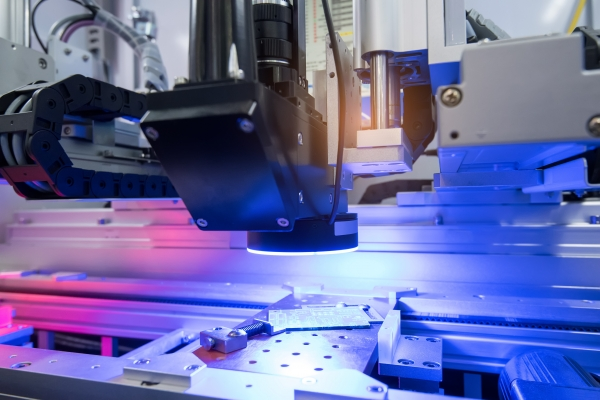

In [20]:
from PIL import Image
Image.open('./data/images/title.jpg')

CV를 통해 검사원이 직접 불량 검사를 하지 않더라도 자동으로 불량품을 검출할 수 있는 모델을 직접 만들어보는 것. 육안으로 식별 가능한 불량에 대하여 이미지 분류와 객체 탐지까지 진행하는 것이 목표이다.

### 데이터셋

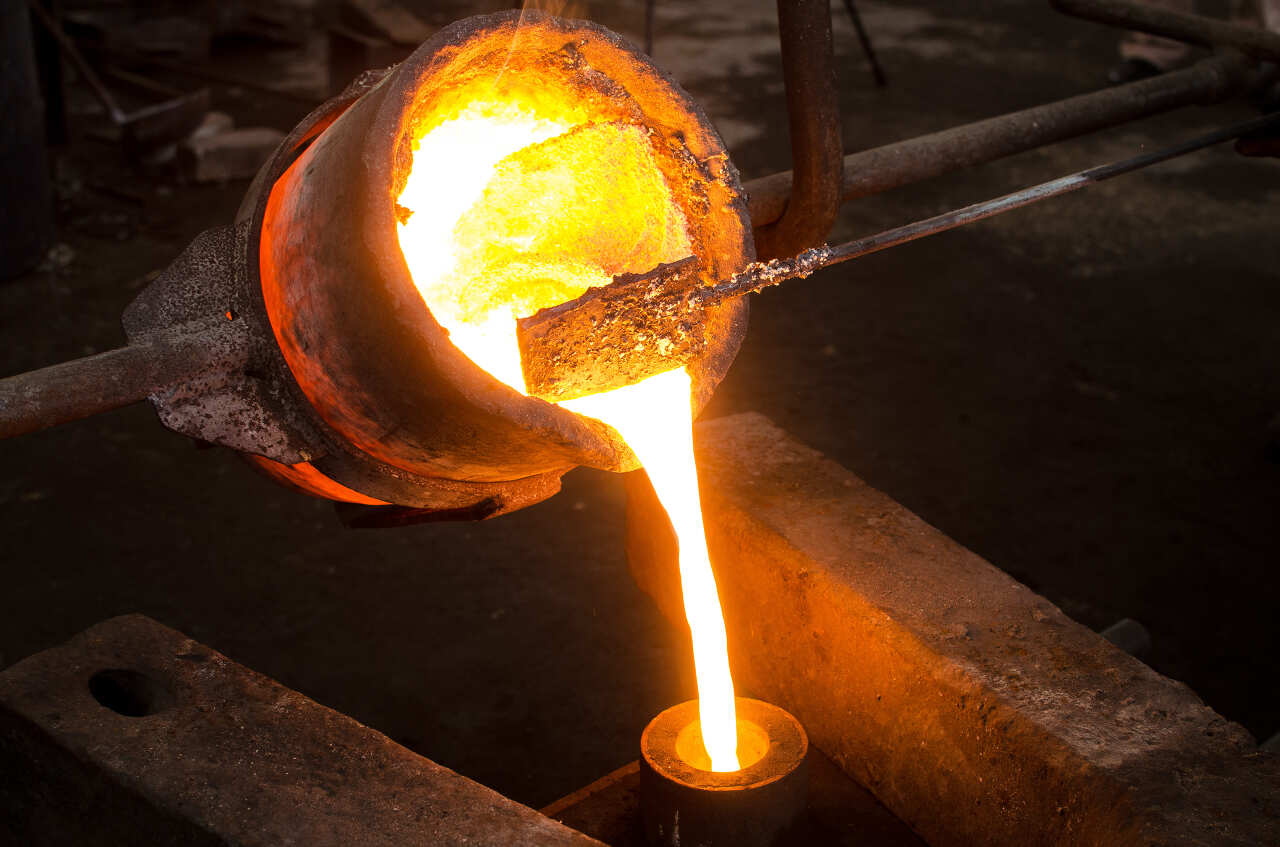

In [19]:
Image.open('./data/images/casting_image.jpg')

캐글에 있는 'casting product image data for quality inspection' 데이터셋을 사용하였으며 주조 제품의 품질관리를 위한 데이터셋이다. 주조는 재료(주로 철, 알루미늄 합금, 구리, 황동 등의 금속)를 융점보다 높은 온도에서 가열하여 액체로 만들어 거푸집에 부어 굳히는 가공 방법이며 이러한 제조 공정에서 일어나는 불량을 감지해내기 위한 모델을 만들기 위해 선정한 데이터셋이다. 분석 대상은 임펠러이고 이 부품은 원심펌프의 회전 요소로 펌프의 스펙을 결정짓는 가장 중요한 부품 중 하나이다. 모터나 엔진이 공급한 에너지를 유체로 전달하는 역할을 한다.

링크: https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product

In [1]:
import tensorflow as tf
import warnings
import cv2, os, glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings(action='ignore') #에러 무시

In [2]:
from model import *

C:/Users/novam/project4/checkpoints/trained_weights_casting.h5 model, anchors, and classes loaded.
C:/Users/novam/project4/checkpoints/trained_weights_helmet.h5 model, anchors, and classes loaded.


In [15]:
def image_view(x=5, y=5, path = '/data/casting_1/test/ok_front/', fm='jpeg'):
    
    image_path = os.path.join(os.getcwd()+ path)
    img_files = glob.glob(image_path+f'*.{fm}')
    
    images = []
    for i in img_files:
        images.append(cv2.imread(i))
        
    plt.figure(figsize=(12,12))

    for index in range(x*y):
        plt.subplot(x, y, index + 1)
        plt.imshow(images[index])
        plt.axis('off')
    
    plt.show()

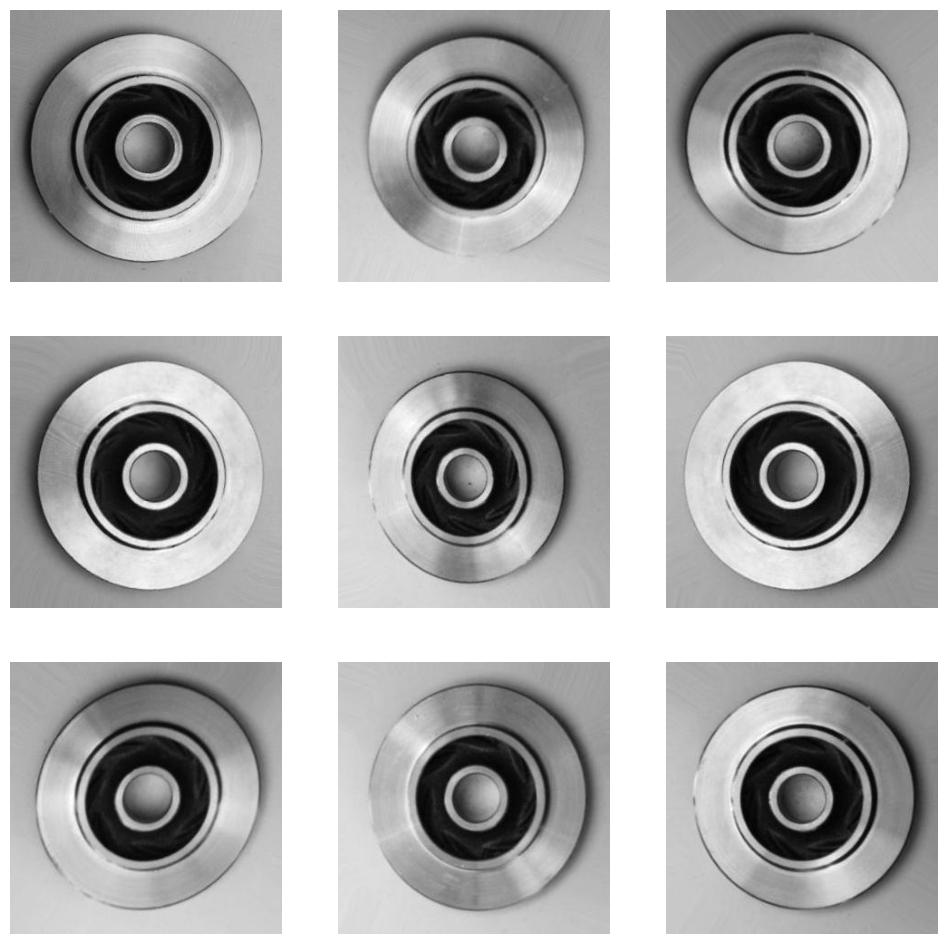

In [17]:
image_view(3,3)

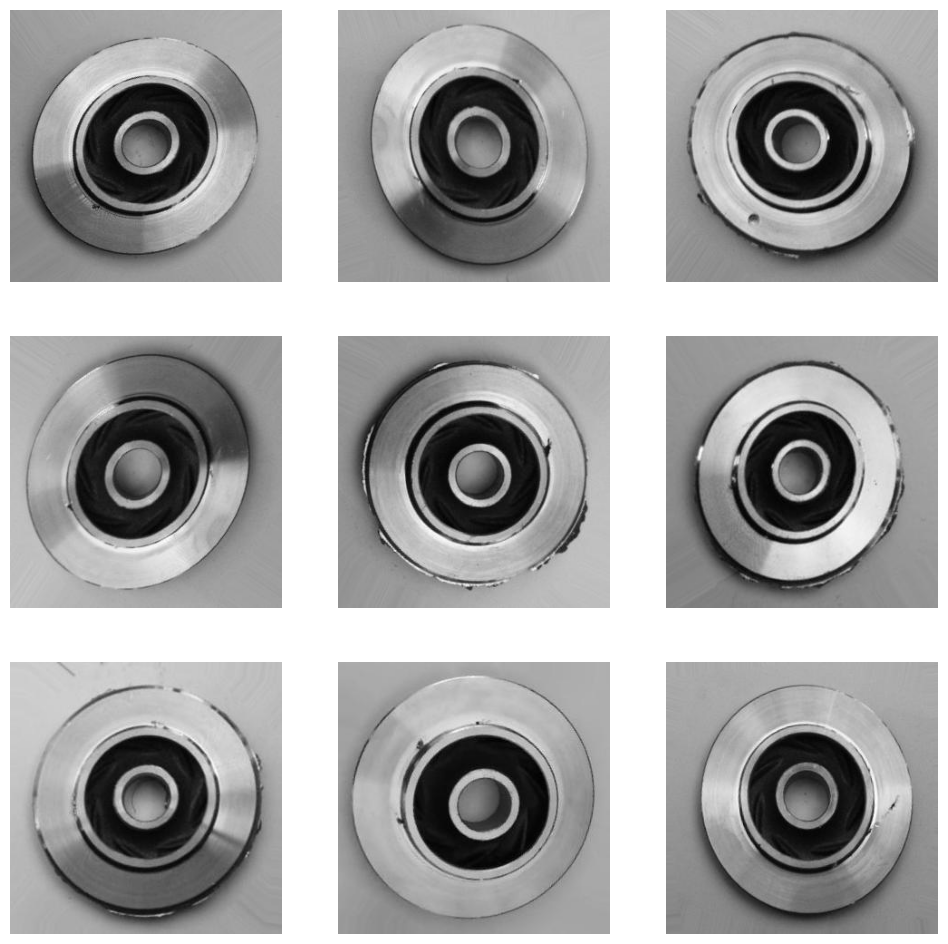

In [16]:
image_view(3,3,'/data/casting_1/test/def_front/')

육안으로 식별 가능한 불량은 3가지: 핀홀, 크랙, 표면 불량

### CNN

이러한 육안으로 식별 가능한 불량을 감지하기 위한 모델을 만들기 위하여 
합성곱 신경망(Convolutional Neural Network)을 선택한 이유는 
1. 데이터셋이 라벨링된 상태임
2. 양품과 불량품의 비율이 그렇게 차이나지 않음.
3. 한정된 상황이기 때문에 상용 모델을 사용하지 못함.
고로 직접 CNN 모델을 만들어 사용하기로 결정.

In [ ]:
def training(model_list, batch_size=30, epochs=20, patience=8, dir_list=scan_dir()):
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor = 'val_accuracy',
                                   min_delta = 0,
                                   patience = patience,
                                   mode = 'max')

    for dir_name in dir_list:
        train, test = train_test(dir_name)
        for deep_model in model_list:

            checkpoint_filepath = './checkpoints/{}.h5'.format(deep_model)

            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=False,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

            tuner = kt.Hyperband(hypermodel = globals()['{}'.format(deep_model)],
                     objective = 'val_accuracy', 
                     max_epochs = epochs,
                     factor = 3,
                     directory = 'checkpoints',
                     project_name = deep_model)
            
            tuner.search(train, validation_data=test)
            
            best_hps = tuner.get_best_hyperparameters()[0]
            model = tuner.hypermodel.build(best_hps)

            hist = model.fit(train, 
                  batch_size=batch_size,
                  validation_data=test,
                  epochs=100,
                  callbacks=[early_stopping, model_checkpoint_callback])

            save_plt(hist, dir_name) # model.py의 함수
            print('{} 모델 저장 완료.'.format(dir_name))

In [ ]:
def CNN(hp):
    from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
    
    hp_unit1 = hp.Int('units_1', min_value = 24, max_value = 48, step = 4)

    inputs = tf.keras.Input(shape=[300, 300, 3])
    x = inputs

    x = Conv2D(hp_unit1, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D(2,2)(x)
    x = Conv2D(2*hp_unit1, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D(2,2)(x)
    x = Conv2D(2*hp_unit1, 3, padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(hp.Int('dense_num', min_value = 64, max_value = 128, step=16), activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
    
    return model

모델은 이런식으로 구현하였다.

In [ ]:
def load_model(model_name):
    checkpoint_filepath = './checkpoints/{}.h5'.format(model_name)
    model = keras.models.load_model(checkpoint_filepath)
    return model

In [302]:
model = load_model('CNN')

In [303]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 300, 300, 28)      784       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 150, 150, 28)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 56)      14168     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 56)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 56)        2828

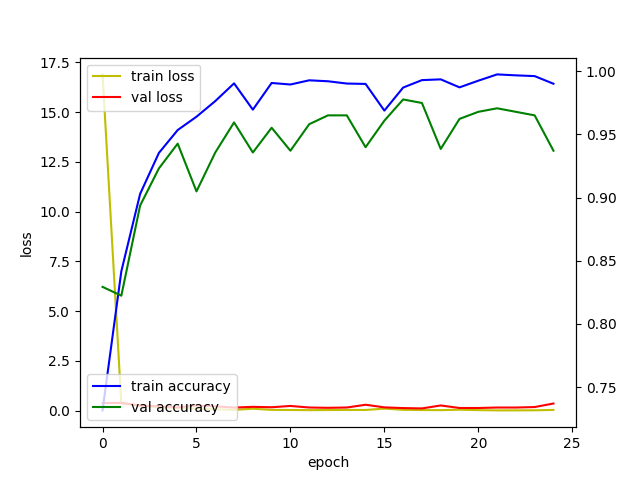

In [12]:
Image.open('./data/plt_image/model_casting_1.png')

하이퍼 파라미터 조정에는 Hyperband를 사용했으며 GTX 2070 SUPER 8GB로 최적의 하이퍼 파라미터를 찾기까지 1시간정도 소요되었다.

In [176]:
evalate_model('casting_1', 'CNN')

Found 6633 files belonging to 2 classes.
Found 715 files belonging to 2 classes.


[0.15689134091624748, 0.9776224]

결과적으로 test set으로 model.evalate를 수행한 결과 accuracy가 0.978로 높은 수치를 기록하였다. 하지만 이러한 이미지 분류로는 정확한 사후 분석이 어렵다 판단하여 yolo3-keras를 이용하여 객체 탐지 모델또한 구현하기로 하였다.

### Yolo v3 Keras

https://github.com/qqwweee/keras-yolo3 의 train.py을 학습에 이용하고 yolo.py를 객체 감지에 이용하였다. yolo_weight.h5는 darknet의 가중치를 사용하였다.

model.py: 프로젝트 메인 파일
    train.py: yolo3 학습 파일
    yolo.py: YOLO 클래스
        model.py: yolo3 모델 파일
        utils.py: letterbox_image
        
위의 yolo3-keras는 
Python 3.5.2
Keras 2.1.5
Tensorflow 1.6.0

버전에서 구동되었으나 앞의 CNN 모델에서 다른 버전의 파이썬과 Keras를 이용하여 어느정도 코드를 수정하여야 했다.

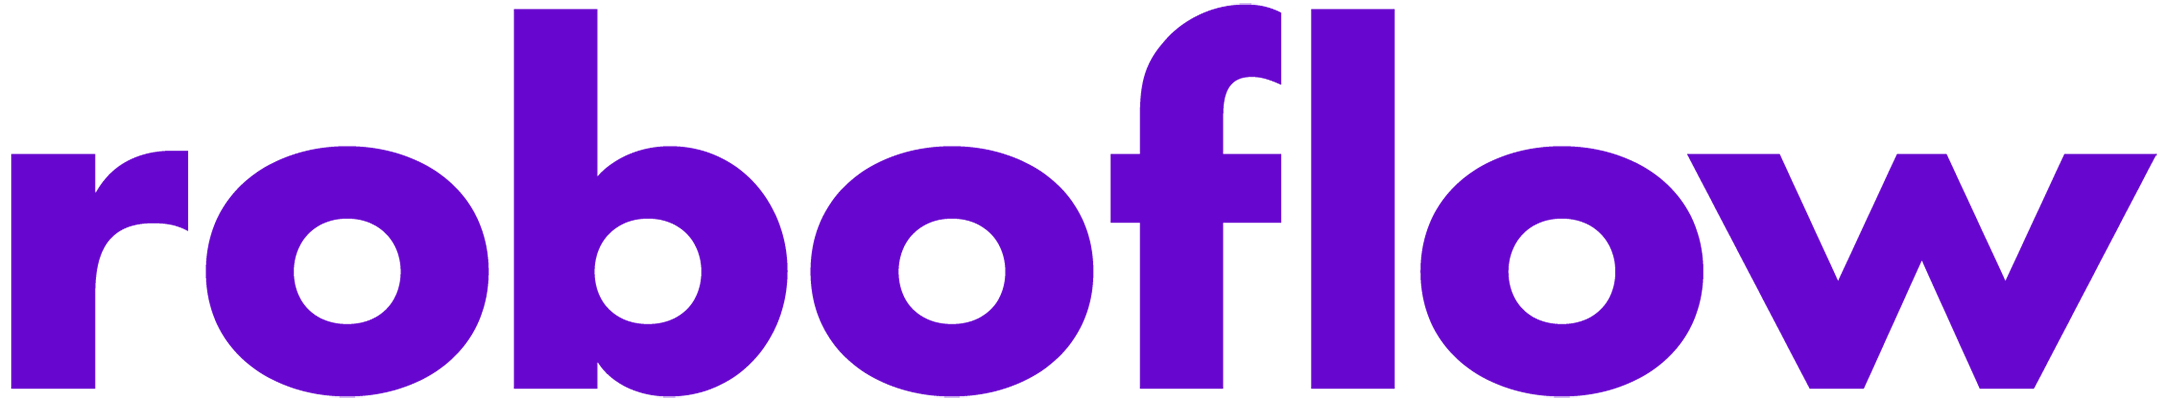

In [14]:
Image.open('./data/images/roboflow.png')

우선적으로 volo3-keras는 찾을 객체에 대하여 바운딩 박스를 쳐놓는 라벨링 절차가 필요하다. 그러한 라벨링을 하기 위하여 roboflow라는 앱을 통하여 라벨링을 진행하였다.

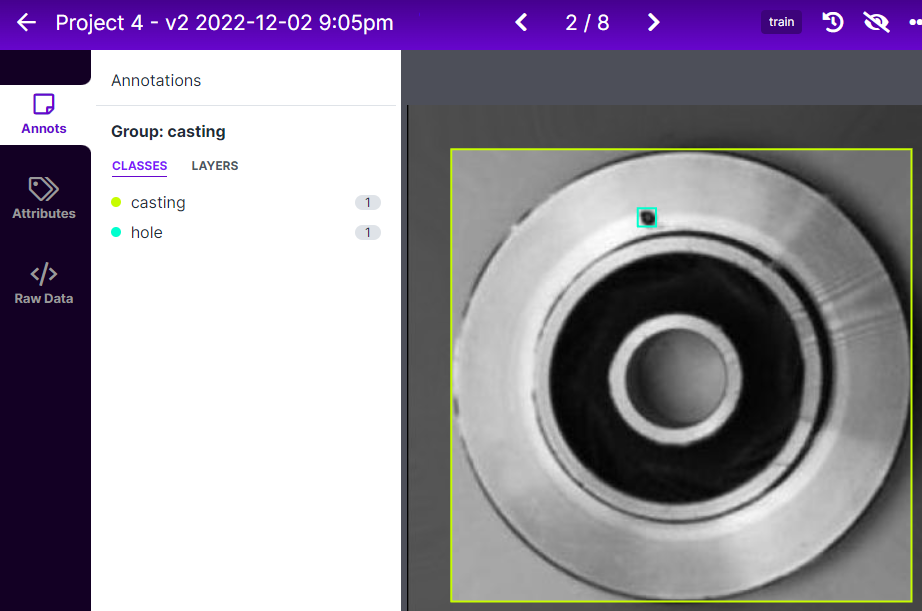

In [15]:
Image.open('./data/images/labeling.png')

육안으로 확인 가능한 불량에 대해서는 크게 3가지 정도로 구분 가능하지만 모든 유형에 대해서 라벨링을 하기에는 시간이 오래 걸리기에 핀홀 불량에 대해서만 라벨링을 진행하였다.
총 55장을 라벨링하였고 이미지 증강을 통해 train set을 95장으로 늘려 학습을 진행하였다. train.py를 통하여 학습을 했으며 trained_weights_casting.h5가 그 결과물이다.

batch_size는 8로 지정하였으며 첫번째 epochs는 50으로 지정하고 50 epochs 이후에는 학습률을 조정해가며 결과적으로는 100 epochs까지 진행된다. callbacks으로 early stopping이 적용되어 있어 86 epochs에 학습이 중단되었다. 학습시에 VRAM이 7GB 정도 사용되어 어느정도의 GPU VRAM이 필요함을 알수있었다. 더 낮은 환경에서 구동시에는 batch_size를 더 줄여야 할 것이다.

그 후에는 yolo.py에 있는 YOLO 클래스의 detect_image 함수를 이용하여 제대로 모델이 작동하는지 확인하였다.

In [ ]:
def test_image(x):
    img_1 = os.listdir('./data/casting_1/test/def_front/')[x]
    load_image = Image.open(f'./data/casting_1/test/def_front/{img_1}')
    resize_image = load_image.resize((416,416))
    final_img = casting_yolo.detect_image(resize_image)[0]
    plt.imshow(final_img)

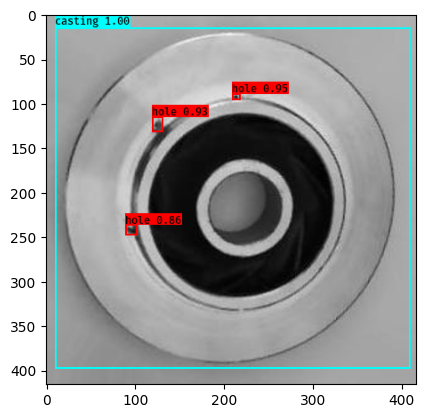

In [16]:
test_image(7)

많은 양을 라벨링하지 않았지만 사진들이 크게 변화가 없기 때문에 단순히 모델을 적용한 것 만으로도 작은 핀홀까지 잘 검출하는 결과를 볼수있었다. score가 꽤나 높게 나오는 것을 확인할 수 있다. 일정 score를 넘으면 바운딩 박스가 나오는데 이를 0.55로 설정하였다.

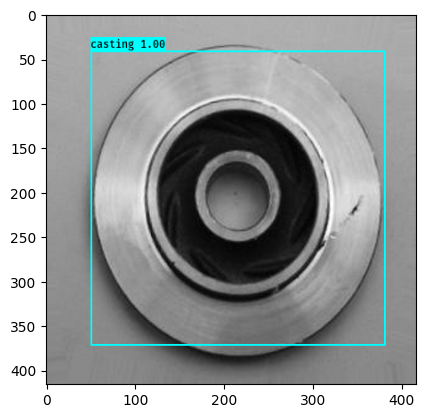

In [21]:
test_image(8)

하지만 라벨링하지 않은 스크레치에 대해서는 검출하지 못하였다. 하지만 이는 의도한 바이니 후에 스크레치에 대한 라벨링을 진행한다면 문제가 없다 판단하였다.

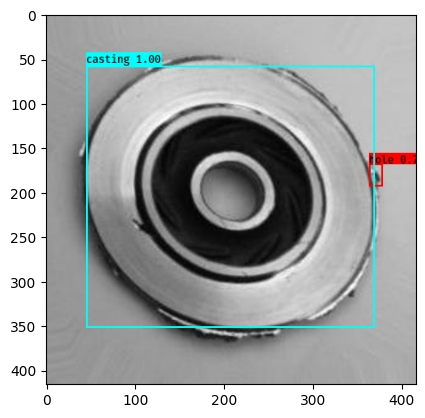

In [23]:
test_image(11)

하지만 이와같이 핀홀 불량이 아님에도 불구하고 casting 바운딩 박스를 넘어선 hole 바운딩 박스가 있는 것을 발견할 수 있었다. 후에 hole 바운딩 박스의 좌표로 통계를 내기 위해선 이러한 casting 바운딩 박스를 넘어서는 hole 바운딩 박스를 따로 분류할 필요가 있었다. 이를 위해서 기존 detect_image의 함수를 수정하여 image 이외에도 바운딩 박스의 라벨과 좌표를 불러오도록 수정하였다.

In [ ]:
def detect_image(self, image, view=False): # yolo.py의 함수
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        if view == True: print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        if view == True: print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='yolo3/font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        label_list = []
        coordinate_list = []

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            if view == True: print(label, (left, top), (right, bottom))
            label_list.append(predicted_class) # label_list 저장
            coordinate_list.append([top, bottom, left ,right]) # 좌표계 저장


            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        if view == True: print(end - start)
        return image, label_list, coordinate_list

좌표계를 불러와 원의 방정식을 이용하여 casting 바운딩 박스 x,y 길이의 평균의 반을 R로 설정하여 R의 제곱을 넘어가는 hole 바운딩 박스의 x,y 좌표가 나온다면 이를 pin_hole 결합이 아님으로 분류하는 과정이 필요하였다.

In [ ]:
def detect_images(folder_name='casting_1', base='casting', target='hole'): # model.py의 함수

    image_list = os.listdir(f'./data/{folder_name}/detect/')
    hole_list = []

    for image in image_list: # 폴더의 이미지를 불러와 (416,416)으로 리사이징
        load_image = Image.open(f'./data/{folder_name}/detect/{image}')
        resize_image = load_image.resize((416,416))
        detected_img, label_list, coordinate_list = casting_yolo.detect_image(resize_image)
        label_num = label_list.count(target)

        if label_num > 0: 
            base_co = coordinate_list.pop(label_list.index(base))
            top, bottom, left ,right = base_co
            R = (bottom-top+right-left)/4 # casting 바운딩 박스의 x,y 길이 평균의 반을 원의 반지름으로 설정
            
            for coordinate in coordinate_list:
                a,b,c,d = coordinate
                temp = [[a,c],[a,d],[b,c],[b,d]]
                trigger = False

                for y,x in temp: # casting의 원밖으로 나가는 hole 바운딩 박스가 나올시 pin_hole 불량이 아님으로 판정
                    if ((x-(left+(right-left)/2))**2)+((y-(top+(bottom-top)/2))**2) > R**2:
                        os.makedirs(f'./data/{folder_name}/detected/target_contour/', exist_ok=True)
                        detected_img.save(f'./data/{folder_name}/detected/target_contour/{image}','JPEG')
                        trigger = True
                        break

                if trigger == True: break
                else: hole_list.append([c+(d-c)/2, a+(b-a)/2, (b-a)*(d-c)]) # [중앙 좌표, 크기]

            if trigger == True: continue

        os.makedirs(f'./data/{folder_name}/detected/target_{label_num}/', exist_ok=True)
        detected_img.save(f'./data/{folder_name}/detected/target_{label_num}/{image}','JPEG')
    
    f = open(f'./data/{folder_name}/hole.csv', 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)
    for hole in hole_list: # hole 좌표, 크기 csv 파일로 저장
        wr.writerow(hole)
    f.close()

<BarContainer object of 5 artists>

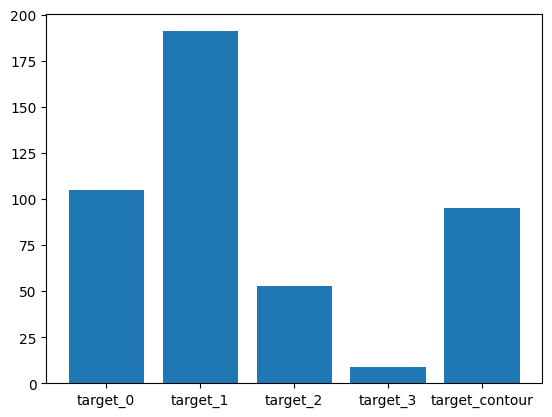

In [10]:
plt.bar(x=count_detect_image('casting_1').keys(), height=count_detect_image('casting_1').values())

이를 통해 분류한 결과 hole이 검출되지 않은 사진은 105개로 분류되었고 차례대로 191개, 53개, 9개로 분류되었다. hole의 바운딩박스가 넘어간 사진은 95개나 되었다. 분류를 진행한 사진들 전부 결함 판정을 받은 제품의 사진이란 것을 생각해보면 모든 종류의 결함을 바운딩 박스를 라벨링 하는 것이 아니라면 객체 탐지를 통한 1차적인 불량품 검출은 힘들다는 결론을 내렸다.

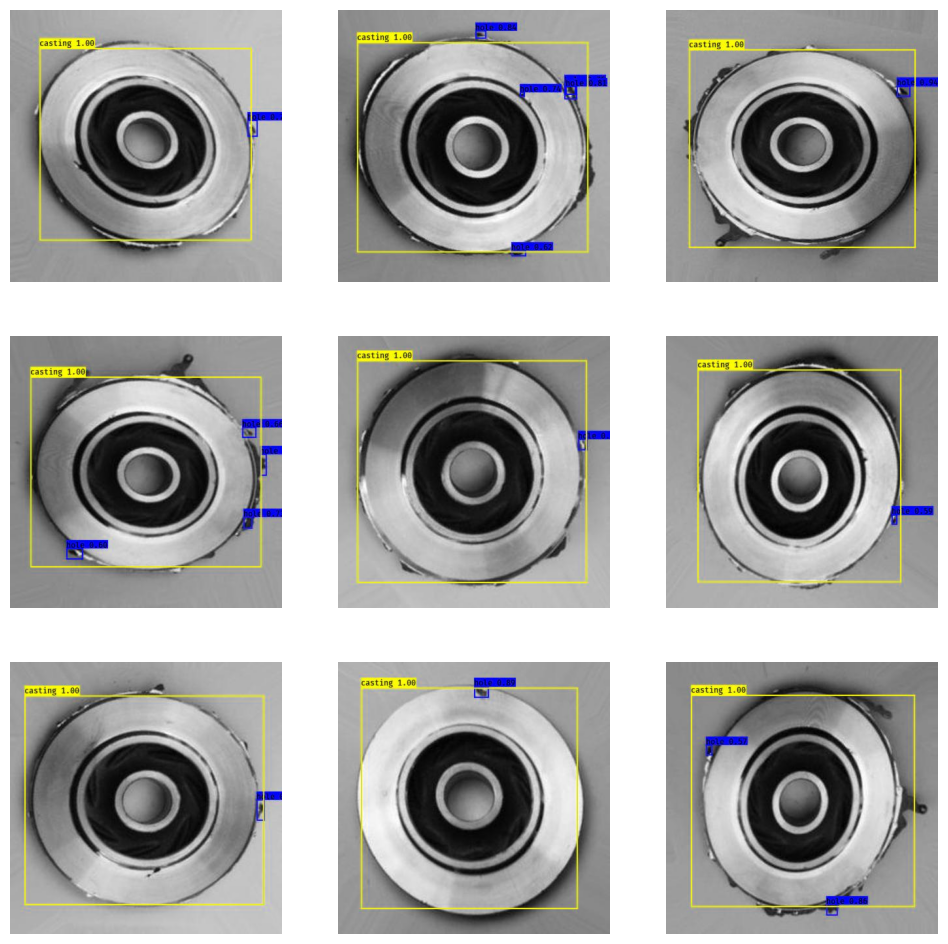

In [14]:
image_view(3, 3, './data/casting_1/detected/target_contour/')

바운딩 박스가 벗어난 사진들을 보면 대부분은 hole 결함이 아닌 것으로 나왔으나 아래 중앙 사진을 보면 경계선에 걸쳐있는 pin_hole 결함또한 존재한다는 것을 알수있다. 이는 후에 R의 제곱에 상수를 더하는 형식으로 민감도를 조절 가능하다고 판단하였다.

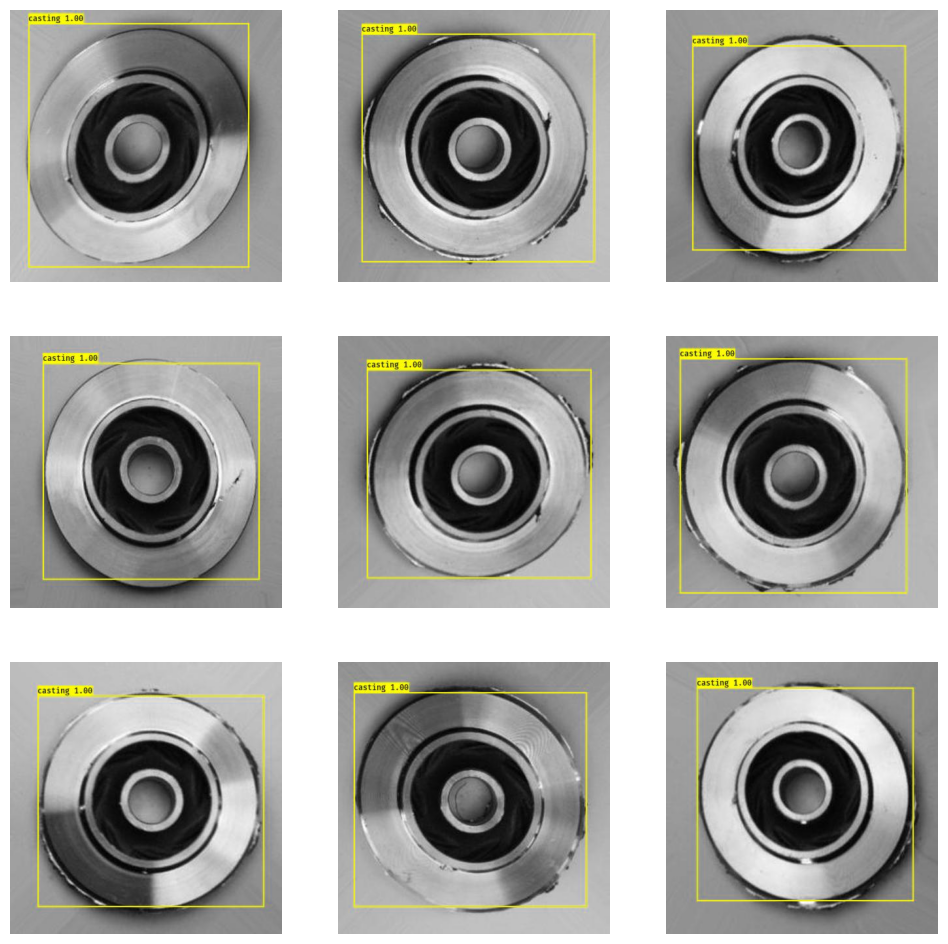

In [15]:
image_view(3, 3, './data/casting_1/detected/target_0/')

target값이 0인 즉, hole 결함이 검출되지 않은 사진들에선 당연히 다른 결함들만이 발견되었다.

In [46]:
def scatter_plot_size(folder_name='casting_1'):
    f = open(f'./data/{folder_name}/hole.csv', 'r', encoding='utf-8', newline='')
    rdr = csv.reader(f)
    x_list = []
    y_list = []
    size_list = []
    for x, y, size in rdr:
        x_list.append(float(x))
        y_list.append(float(y))
        size_list.append(float(size))
    f.close()
    
    fig, ax = plt.subplots()
    img = plt.imread("./data/images/casting.jpeg")
    ax.imshow(img, extent=[0, 416, 0, 416])
    plt.scatter(x=x_list, y=y_list, c=size_list, cmap='Reds')
    plt.xlabel('X-Axis')
    plt.ylabel('Y-Axis')
    plt.title('Hole Scatter')
    plt.colorbar(label='size')
    plt.show()

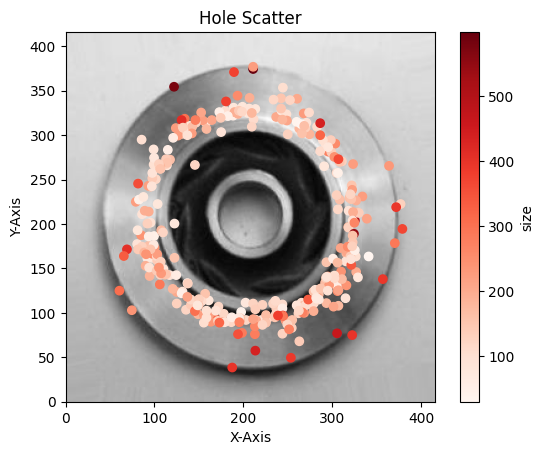

In [47]:
scatter_plot_size()

앞서 수집한 hole의 좌표와 바운딩 박스의 크기를 색으로 표현한 scatter plot이다. 대부분의 hole은 중앙 주위에 분포하고 외곽으로 갈수록 큰 hole이 있는 것을 확인 할 수 있다. 이러한 데이터는 품질관리를 함에 있어서 결함의 이유를 추측할 수 있는 데이터가 될 것이다.

### CNN and YOLO

앞서 만든 CNN 모델을 test set으로 predict한 결과이다.

In [300]:
def test_image_view(path_list, x=3, y=3, z=9):
    
    images = []
    for i in path_list:
        images.append(cv2.imread(i))
        
    plt.figure(figsize=(12,12))

    for index in range(z):
        plt.subplot(x, y, index + 1)
        plt.imshow(images[index])
        plt.axis('off')
    
    plt.show()

In [301]:
def image_load_and_preprocessing(path = '/data/casting_1/test/ok_front/'):
    from tensorflow.keras.utils import img_to_array, load_img, array_to_img
    
    image_path = os.path.join(os.getcwd()+ path)
    img_files = glob.glob(image_path+'*.jpeg')
    images = []
    
    for i in img_files:
        images.append(img_to_array(load_img(i)))
        
    return np.array(images), img_files

In [215]:
image_load_and_preprocessing()[0].shape

(262, 300, 300, 3)

In [280]:
y_prob = model.predict(image_load_and_preprocessing()[0])
y_prob[y_prob >= 0.5] = 1
y_prob[y_prob < 0.5] = 0
fn_list = np.where(y_prob == 0)[0].tolist()
fn_images = []

for i in fn_list:
    fn_images.append(image_load_and_preprocessing()[1][i])

unique, counts = np.unique(y_prob, return_counts=True)
dict(zip(unique, counts))

{0.0: 9, 1.0: 253}

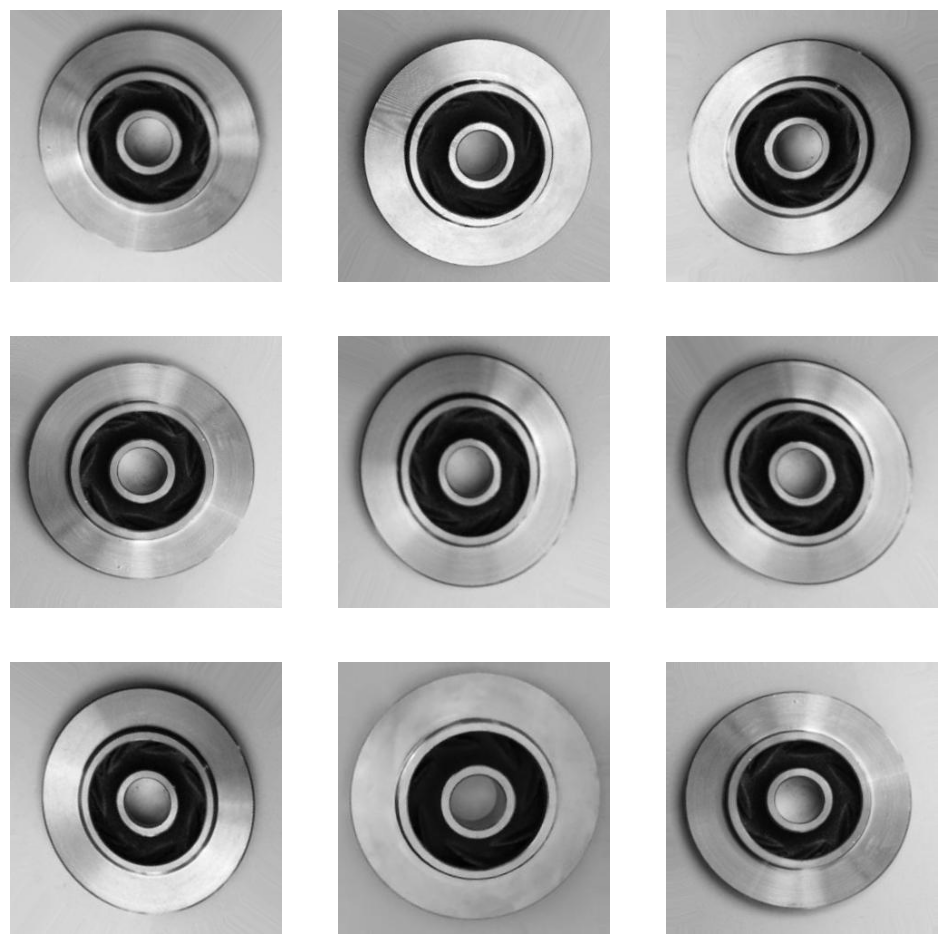

In [281]:
test_image_view(fn_images, x=3, y=3, z=9)

양품인 데이터셋으로 predict한 결과 FN인 결과는 262개 중 9개로 외관을 보고는 불량품임을 알기 힘든 데이터들이다. 광원 때문에 나온 결과라 생각한다. 이는 저 많은 데이터셋을 학습시키면 해결될 것이다.

In [225]:
image_load_and_preprocessing('/data/casting_1/test/def_front/')[0].shape

(453, 300, 300, 3)

In [284]:
y_prob = model.predict(image_load_and_preprocessing('/data/casting_1/test/def_front/')[0])
y_prob[y_prob >= 0.5] = 1
y_prob[y_prob < 0.5] = 0
fp_list = np.where(y_prob == 1)[0].tolist()
fp_images = []

for i in fp_list:
    fp_images.append(image_load_and_preprocessing('/data/casting_1/test/def_front/')[1][i])

unique, counts = np.unique(y_prob, return_counts=True)
dict(zip(unique, counts))

{0.0: 445, 1.0: 8}

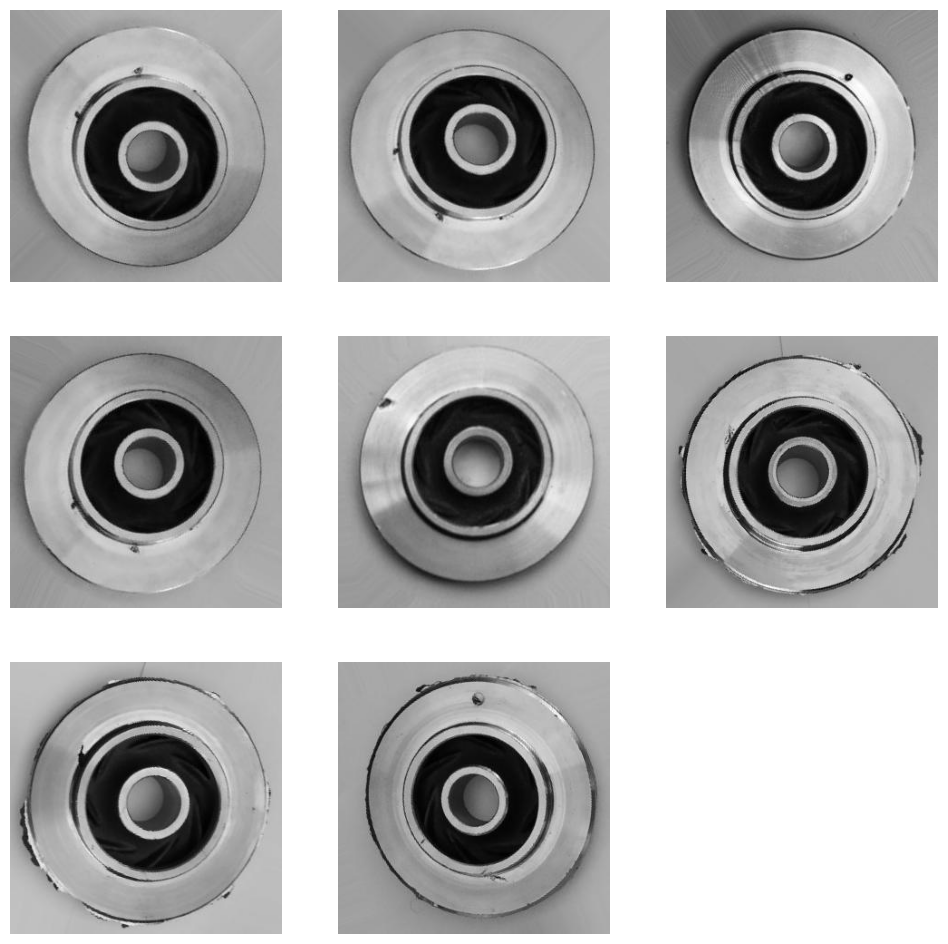

In [285]:
test_image_view(fp_images,x=3, y=3, z=8)

CNN 모델에서 걸러지지 않은 FP 판정의 사진들이다. 위 사진들에서 볼수 있듯이 작은 hole 때문에 걸러지지 않은 경우가 많았다. 이를 보완하기 위하여 yolo 모델을 적용시킨다면 FP들의 수를 줄일수 있을 것이다.

In [319]:
def test_fp_images(path_list=fp_images):
    from yolo3.yolo import detect_video
    
    images = []

    for i in path_list:
        temp = Image.open(i).resize((416,416))
        images.append(casting_yolo.detect_image(temp)[0])
    
    plt.figure(figsize=(12,12))

    for index in range(8):
        plt.subplot(3, 3, index + 1)
        plt.imshow(images[index])
        plt.axis('off')
    
    plt.show()

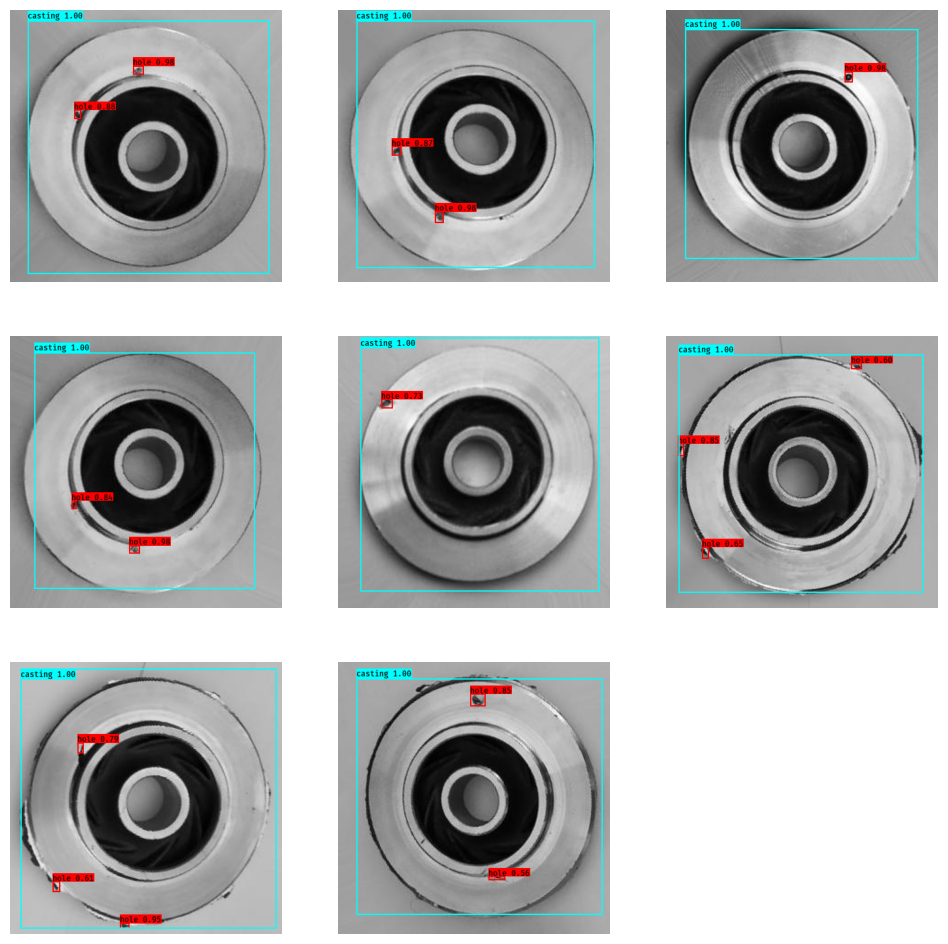

In [320]:
test_fp_images()

모든 사진에서 hole을 검출한 것을 확인할 수 있다. YOLO 패키지의 detect_image 함수에서 정확한 통계를 위해 원밖의 hole에 대한 좌표를 수집하지는 않지만 불량품을 검출하는데 있어서는 pin_hole 불량이 아니어도 불량을 감지하는 점은 장점이 될수있다. 이렇게 CNN과 yolo를 둘다 활용하여 CNN 모델에서 양품이라 판단한 제품들에 한에서 yolo 모델로 재검수를 거쳐 accuracy를 0.9874까지 증가시킬 수 있었다.

### 영상 처리

역시 yolo 모델을 이용하면서 영상 처리를 안하기에는 아쉽다는 생각이 들어서 추가로 진행하였다. 안전모의 추적에 관한 모델을 만들기 위해 roboflow dataset중 helmet dataset을 이용하여 모델의 학습을 진행하였다.

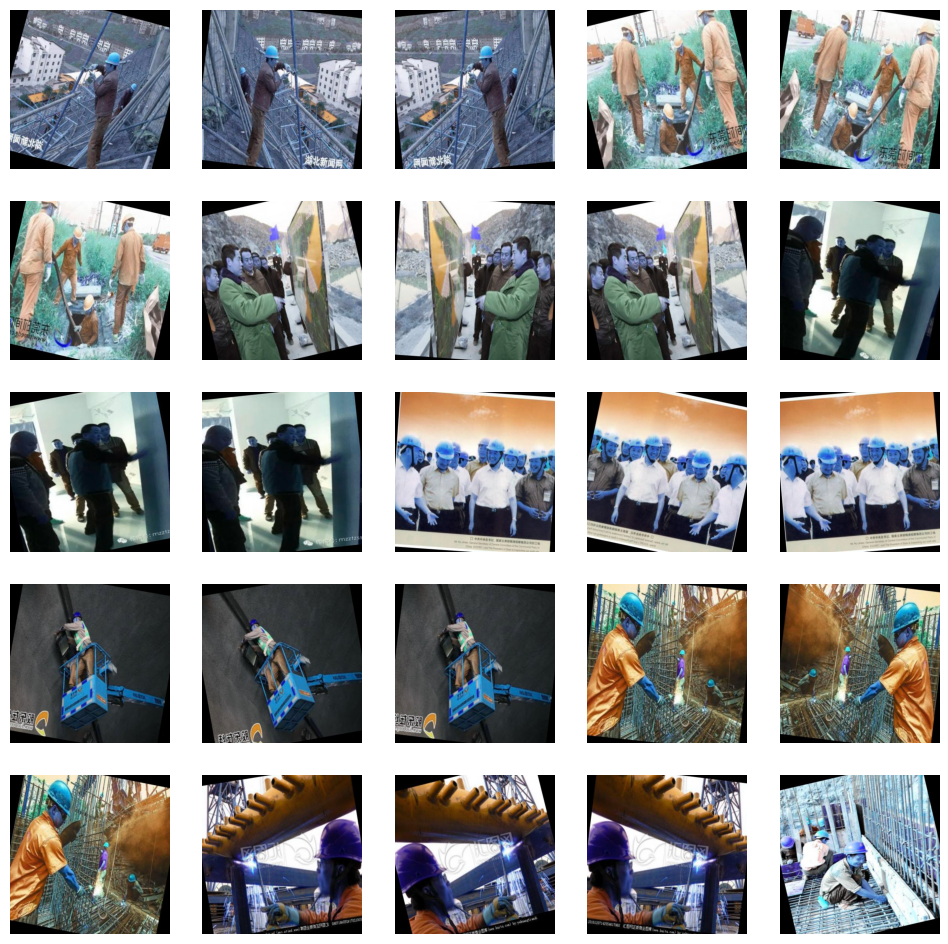

In [323]:
image_view(5, 5, './data/yolo3_train/', 'jpg')

데이터 증강을 실시한 사진들의 모습이다. 위의 casting 모델과 같이 train.py를 통하여 학습을 진행하였고 그 결과가 trained_weights_helmet.h5 이다. 그 후 YOLO 패키지의 detect_video 함수를 이용하여 영상을 처리하였다.

In [11]:
def play_video(path='./data/videos/test_video.mov'):

    capture = cv2.VideoCapture(path)

    while capture.isOpened():
        run, frame = capture.read()
        if not run:
            break
        img = cv2.cvtColor(frame, cv2.IMREAD_COLOR)
        cv2.imshow('video', frame)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    capture.release()
    cv2.destroyAllWindows()

In [14]:
play_video()

In [ ]:
detect_video(helmet_yolo,'./data/videos/test_video.mov', './data/videos/detect_video.mov')

In [15]:
play_video('./data/videos/detect_video.mov')

이렇게 안전모가 캡처되는 것을 확인할 수 있다. 안전모의 경우 근로자를 구별하기 위해 색깔을 구분시켜 놓는데 이를 이용하여 근로자의 유형 별로 추적이 가능하게끔 만들수도 있을 것이다. 이러한 학습을 시도할때 학습을 원하는 클래스의 색상에 맞게 색반전 데이터 증강을 시킨다면 한정된 데이터셋으로도 여러 근로자를 분류하는 모델을 만들수 있을 것이라 생각한다. 물론 이번 프로젝트에서 영상 처리는 부록같은 느낌이라 안전모 추적 기능만을 학습시켰다.

### 결론

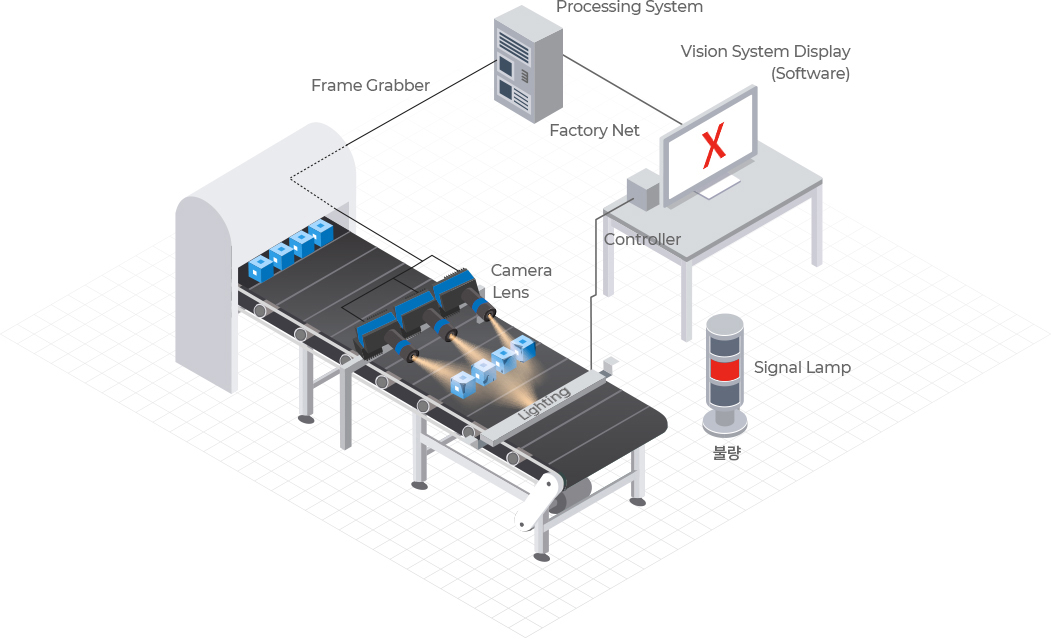

In [23]:
Image.open('./data/images/vis.jpg')

이 사진은 실제 제조산업에서 사용하고 있는 머신비전이다. 최근에서야 생겨난 개념이 아닌 1980년대 이전에도 사용해왔던 기술이다. 최근 광학 기술의 고도화와 딥러닝등이 생겨나며 과거에 비해서 좀더 정확하고 분석적인 품질 검사가 가능하게 되었다. 그로인해 머신비전에 대한 개발과 수요는 꾸준히 증가하는 추세를 보이고 있다고 한다. 이러한 이유 때문에 CV에 관심이 있기도 했고 그걸 직접 구현해보는 경험은 새로웠다. 물론 내가 한 부분은 아주 일부분에 불과하고 현장에서는 ICT적인 요소들도 많이 필요할 것이라 생각한다.

이번 프로젝트에서 사용한 데이터셋의 픽셀은 300으로 화질도 그렇게 좋지 않고 라벨링 또한 그렇게 많이 진행하지 않았지만 생각보다 만족스러운 성능의 모델이 나온 것 같아 다행이라는 생각이 들었다. 그리고 모델을 만드는 것에 멈추지 않고 그것을 통한 유의미한 분석을 해본 것 또한 만족스러웠다.

이번 프로젝트를 기획하고 진행하는 과정에서 가장 난관을 겪었던 곳은 다른 사람이 쓴 코드를 접목시키는 것이었다. 짧은 코드가 아닌 패키지 단위로 불러오는 과정에서 버전이 맞지 않아 현재 버전과 다른 문법을 가진 keras의 라이브러리도 많았고 그로인하여 수정에 시간을 많이 들인 것같다. 기존에 구현되어 있는 것을 손으로 일일히 짜는 것은 비효율적이니 다른 사람의 코드를 읽고 활용하고 수정하여 내가 필요한 기능으로 만드는 것도 중요한 능력인 것을 느꼈다. 지금까지 부트캠프를 진행하면서 코드가 내 생각대로 작동한다면 다른 사람의 코드를 보지 않았지만 이제부터는 어떻게 하면 좀더 효율적인 코드를 쓸지에 대하여 고민을 할 필요가 있는 것 같다.

물론 모든 것이 만족스러웠던 것은 아니다. 구현 단계에선 배포 또한 염두하고 있었으나 항상 어느정도 기능이 구현되니까 힘이 빠져버리는 느낌이 있다. 기획 당시에는 음성인식을 통하여 작업자가 세이프 워드를 외치면 작업이 멈추는 기능이라던가 작업자가 불량을 외치면 SQL 로그에 자동으로 라벨링 되게끔 한다거나 하는 기능들도 추가하여 여러 기능을 추가하고 싶었으나 CV에서 멈춰버린 것이 조금 아쉽긴 하다.